In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [2]:
from functions import helpers
from functions import models
from functions import classifiers
from functions import metric

2024-07-12 16:56:21.167766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df_mice = pd.read_csv('../data/data_mice.csv')
df_mice = df_mice[df_mice['Csection.Urgency'] != 'Schedule']
del df_mice['Method.of.Delivery.A']
del df_mice['Csection.Incidence'] 

In [4]:
urgency_mice = df_mice.pop('Csection.Urgency')

In [5]:
labels_mice=LabelEncoder().fit_transform(urgency_mice)
print(Counter(labels_mice))

Counter({1: 12334, 2: 2572, 0: 500})


In [6]:
df_mice.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15406 entries, 0 to 17619
Data columns (total 90 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              15406 non-null  int64  
 1   Gravida                          15406 non-null  int64  
 2   Para                             15406 non-null  int64  
 3   Number.of.Babies.In.Womb         15406 non-null  int64  
 4   Delivery.Year                    15406 non-null  int64  
 5   Infant.Cord.Vessels.A            15406 non-null  int64  
 6   Infant.Length.A                  15406 non-null  float64
 7   Birthweight.A                    15406 non-null  int64  
 8   GA.At.Birth.A                    15406 non-null  float64
 9   Weight.Prepregnancy              15406 non-null  int64  
 10  Weight.Gain.Pounds               15406 non-null  int64  
 11  OFC.At.Birth.Baby.A.In           15406 non-null  float64
 12  Quantitative.Blood

###  Model ( RF / CatBoost)

In [8]:
features = pd.get_dummies(df_mice)

In [9]:
X_train, X_test, y_train, y_test = helpers.split_and_scale_data(features, labels_mice)

In [10]:
print(X_train.shape,X_test.shape)

(10784, 235) (4622, 235)


In [11]:
print(Counter(y_train))

Counter({1: 8608, 2: 1815, 0: 361})


In [12]:
print(Counter(y_test))

Counter({1: 3726, 2: 757, 0: 139})


In [13]:
X_train, y_train = helpers.perform_SMOTE(X_train, y_train)
print(Counter(y_train))

Counter({1: 8608, 2: 8608, 0: 8608})


In [14]:
y_test

array([1, 1, 1, ..., 1, 1, 1])

#### LASSO

#### RF

In [15]:
y_pred_binary2, y_pred2 = classifiers.run_RF(X_train, X_test, y_train, y_test, label='Urgent Csection')

Building model for label: Urgent Csection
Predicting on test data for label: Urgent Csection


In [28]:
print(Counter(y_test))

Counter({1: 3726, 2: 757, 0: 139})


In [29]:
print(Counter(y_pred_binary2))

Counter({1: 2182, 0: 2147, 2: 293})


In [72]:
from sklearn import metrics
def confusion_matrix2(y_true, y_pred):
    plt.figure(figsize = (16,8))
    unique_labels = np.unique(y_true)
    sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot = True,fmt='d',
                annot_kws={"size": 18},xticklabels = unique_labels, yticklabels = unique_labels, cmap = 'summer')
    plt.xlabel('Predicted Labels',fontsize=16)
    plt.ylabel('True Labels', fontsize=16)
    plt.xticks(fontsize=16)  # Change the size of x-tick labels
    plt.yticks(fontsize=16)
    plt.show()

In [54]:
metrics.confusion_matrix(y_test,y_pred_binary2)

array([[ 124,    4,   11],
       [1512, 2176,   38],
       [ 511,    2,  244]])

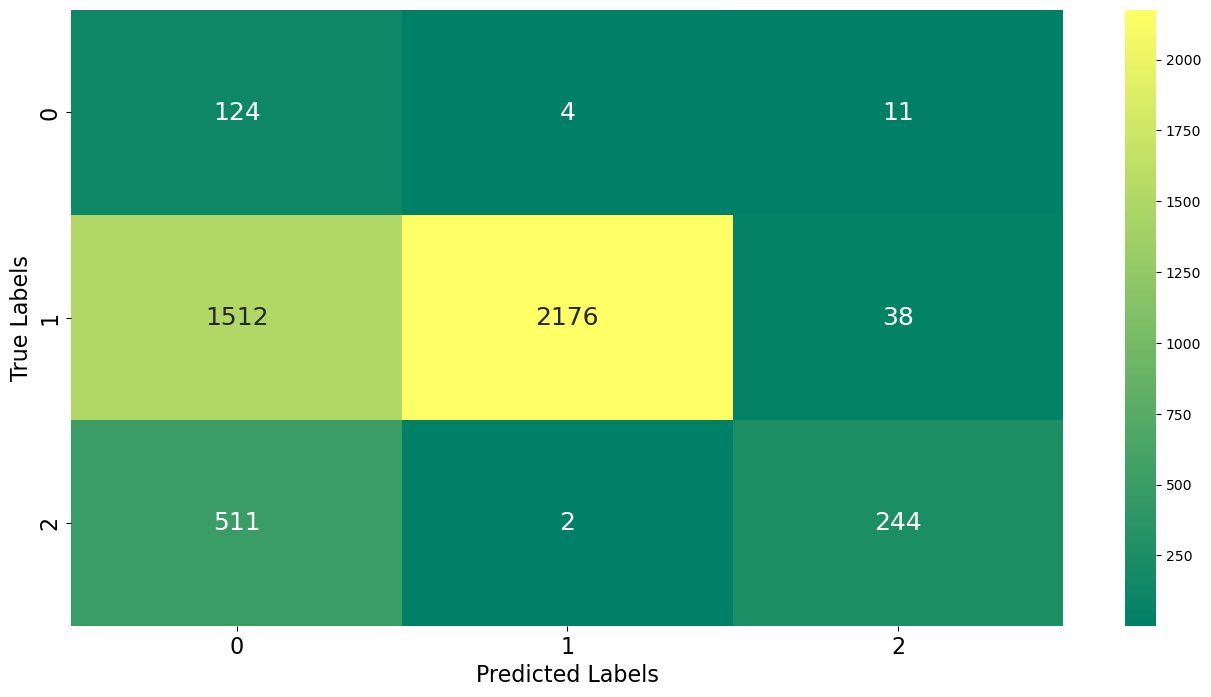

In [73]:
confusion_matrix2(y_test,y_pred_binary2)

In [50]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred_binary2))
print('Accuracy:', metric.accuracy(y_test, y_pred_binary2))
print('Precision:', metric.macro_precision(y_test, y_pred_binary2))
print('Recall:', metric.macro_recall(y_test, y_pred_binary2))
print('F1:', metric.macro_f1(y_test, y_pred_binary2))

AUC: {0: 0.7204130070915384, 1: 0.7886539327888965, 2: 0.6548235442895203}
Accuracy: 0.5504110774556469
Precision: 0.6292565793091276
Recall: 0.599471861686319
F1: 0.43662522030386497


In [99]:
print('Precision:', macro_precision(y_test, y_pred_binary2))
print('Recall:', macro_recall(y_test, y_pred_binary2))
print('F1:', macro_f1(y_test, y_pred_binary2))

Precision: 0.631926202524276
Recall: 0.6080262581134341
F1: 0.4526647874603769


#### CatBoost 

In [51]:
from catboost import CatBoostClassifier
# Create CatBoost classifier
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)

# Fit the classifier to the training data
clf.fit(X_train, y_train, verbose=10)

0:	learn: 0.9904001	total: 144ms	remaining: 14.3s
10:	learn: 0.5572053	total: 476ms	remaining: 3.85s
20:	learn: 0.4302674	total: 811ms	remaining: 3.05s
30:	learn: 0.3661369	total: 1.29s	remaining: 2.87s
40:	learn: 0.3249541	total: 1.85s	remaining: 2.66s
50:	learn: 0.2984105	total: 2.38s	remaining: 2.29s
60:	learn: 0.2753954	total: 2.77s	remaining: 1.77s
70:	learn: 0.2564706	total: 3.12s	remaining: 1.27s
80:	learn: 0.2415546	total: 3.45s	remaining: 809ms
90:	learn: 0.2287052	total: 3.91s	remaining: 387ms
99:	learn: 0.2176657	total: 4.29s	remaining: 0us


In [52]:
# Make predictions on the testing data
y_pred_prob = clf.predict_proba(X_test)

In [57]:
y_pred = clf.predict(X_test)

In [77]:
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [33]:
y_pred_prob_0 = y_pred_prob[,0]

array([[0.1513622 , 0.74696444, 0.10167336],
       [0.19170167, 0.59727311, 0.21102523],
       [0.02956459, 0.94030475, 0.03013066],
       ...,
       [0.01079521, 0.97113331, 0.01807147],
       [0.06504043, 0.86795277, 0.0670068 ],
       [0.09751752, 0.85715   , 0.04533248]])

In [38]:
#y_pred_prob_0 = y_pred_prob[:,0]

In [39]:
#y_pred_prob_0

array([0.1513622 , 0.19170167, 0.02956459, ..., 0.01079521, 0.06504043,
       0.09751752])

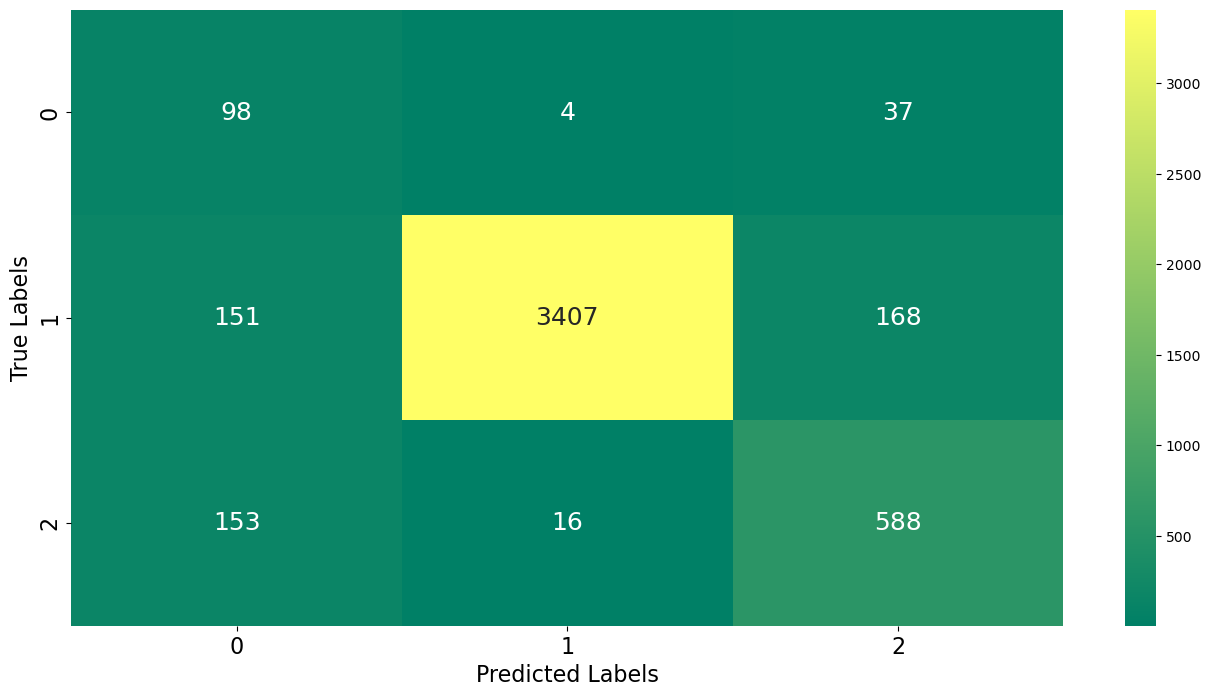

In [74]:
confusion_matrix2(y_test,y_pred)

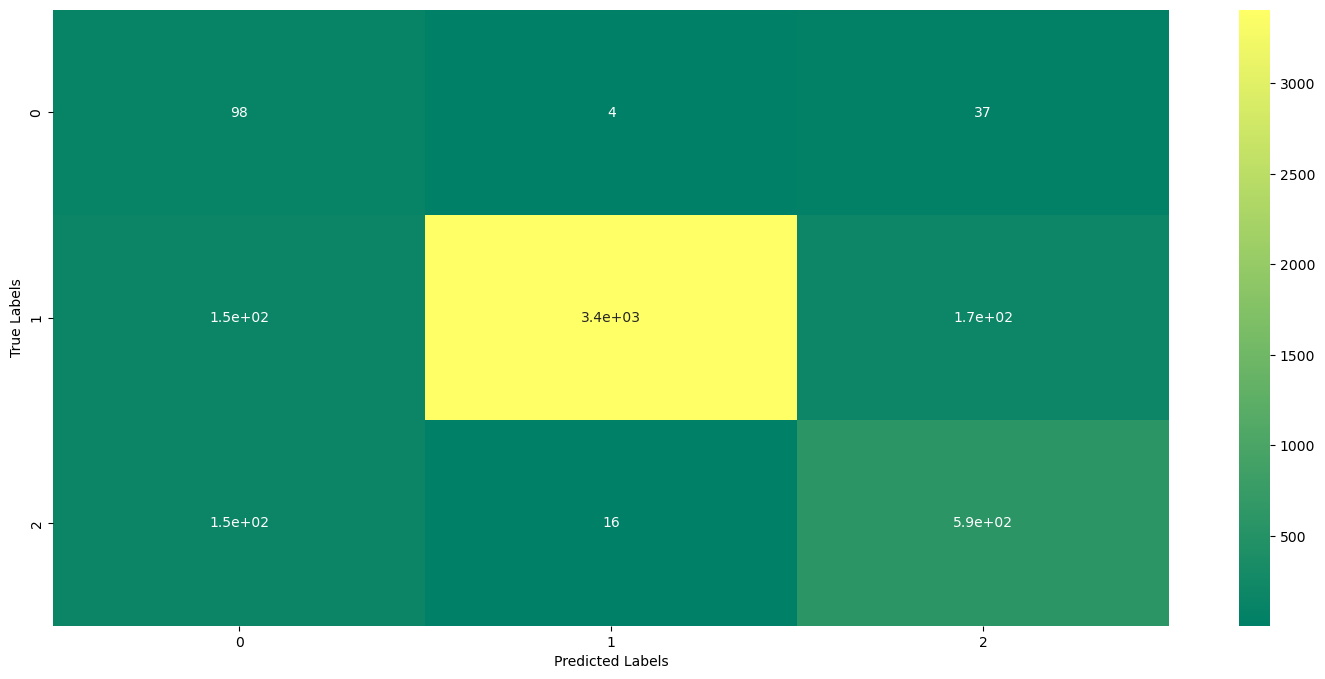

In [78]:
metric.confusion_matrix2(y_test,y_pred)

In [61]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred))
print('Accuracy:', metric.accuracy(y_test, y_pred))
print('Precision:', metric.macro_precision(y_test, y_pred))
print('Recall:', metric.macro_recall(y_test, y_pred))
print('F1:', metric.macro_f1(y_test, y_pred))

AUC: {0: 0.8186121190043281, 1: 0.9460319856606089, 2: 0.861855113379053}
Accuracy: 0.8855473820856772
Precision: 0.6598110349006455
Recall: 0.7987238983409869
F1: 0.6912025478456291


###  Model (AE +LASSO / RF/ CatBoost)

In [62]:
AE_train, AE_test = models.run_AE(X_train, X_test)

145/145 [==============================] - 0s 847us/step


#### RF

In [63]:
y_pred_AErf, y_pred_prob_AE = classifiers.run_RF(AE_train, AE_test, y_train, y_test, label='Urgent Csection')

Building model for label: Urgent Csection
Predicting on test data for label: Urgent Csection


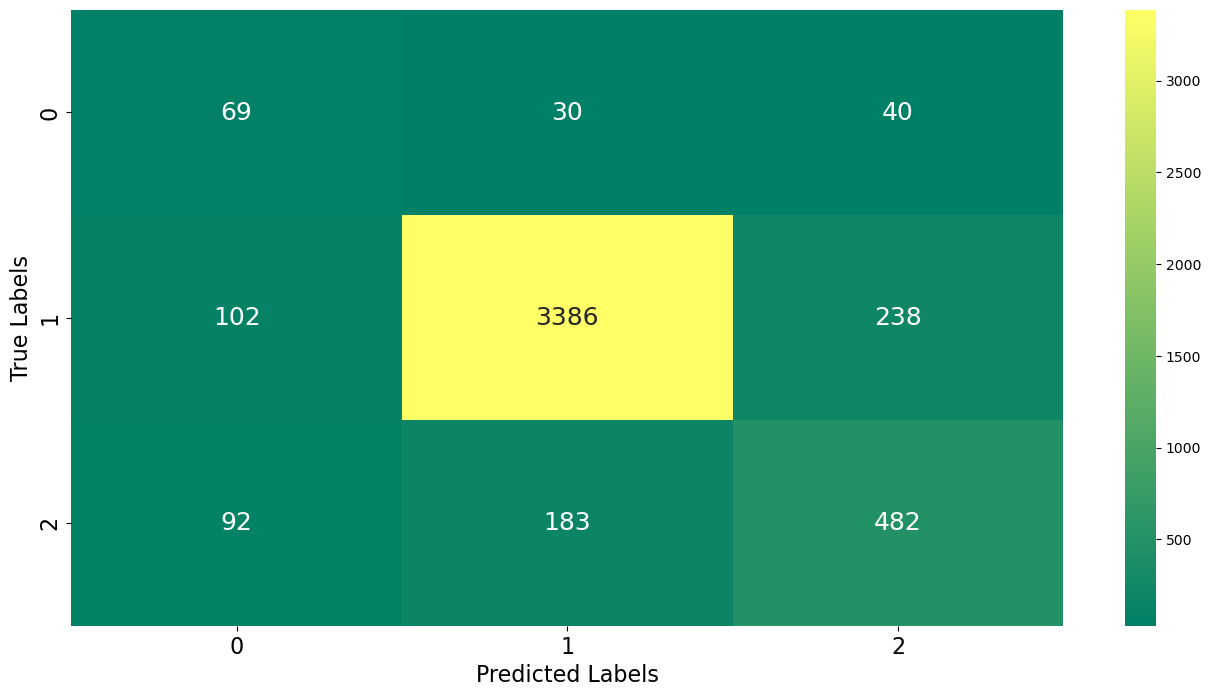

In [75]:
confusion_matrix2(y_test,y_pred_AErf)

In [65]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred_AErf))
print('Accuracy:', metric.accuracy(y_test, y_pred_AErf))

AUC: {0: 0.7265641423956529, 1: 0.835513057376735, 2: 0.7823981775955676}
Accuracy: 0.8517957594115102


In [66]:
print('Precision:', metric.macro_precision(y_test, y_pred_AErf))
print('Recall:', metric.macro_recall(y_test, y_pred_AErf))
print('F1:', metric.macro_f1(y_test, y_pred_AErf))

Precision: 0.6124616107508515
Recall: 0.6806253707508346
F1: 0.6344173264992291


#### CatBoost

In [67]:
## AE+catboost (very fast, because no grid search?)
clf_AE = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6)
# Fit the classifier to the training data
clf_AE.fit(AE_train, y_train, verbose=10)

0:	learn: 1.0637070	total: 75.9ms	remaining: 7.51s
10:	learn: 0.8486636	total: 356ms	remaining: 2.88s
20:	learn: 0.7344671	total: 617ms	remaining: 2.32s
30:	learn: 0.6539458	total: 983ms	remaining: 2.19s
40:	learn: 0.5928646	total: 1.31s	remaining: 1.88s
50:	learn: 0.5452486	total: 1.75s	remaining: 1.69s
60:	learn: 0.5077598	total: 2.05s	remaining: 1.31s
70:	learn: 0.4724170	total: 2.38s	remaining: 972ms
80:	learn: 0.4431873	total: 2.66s	remaining: 623ms
90:	learn: 0.4164494	total: 2.94s	remaining: 290ms
99:	learn: 0.3953750	total: 3.16s	remaining: 0us


In [68]:
# Make predictions on the testing data
y_pred_prob_AEcat = clf_AE.predict_proba(AE_test)
y_pred_AEcat = clf_AE.predict(AE_test)

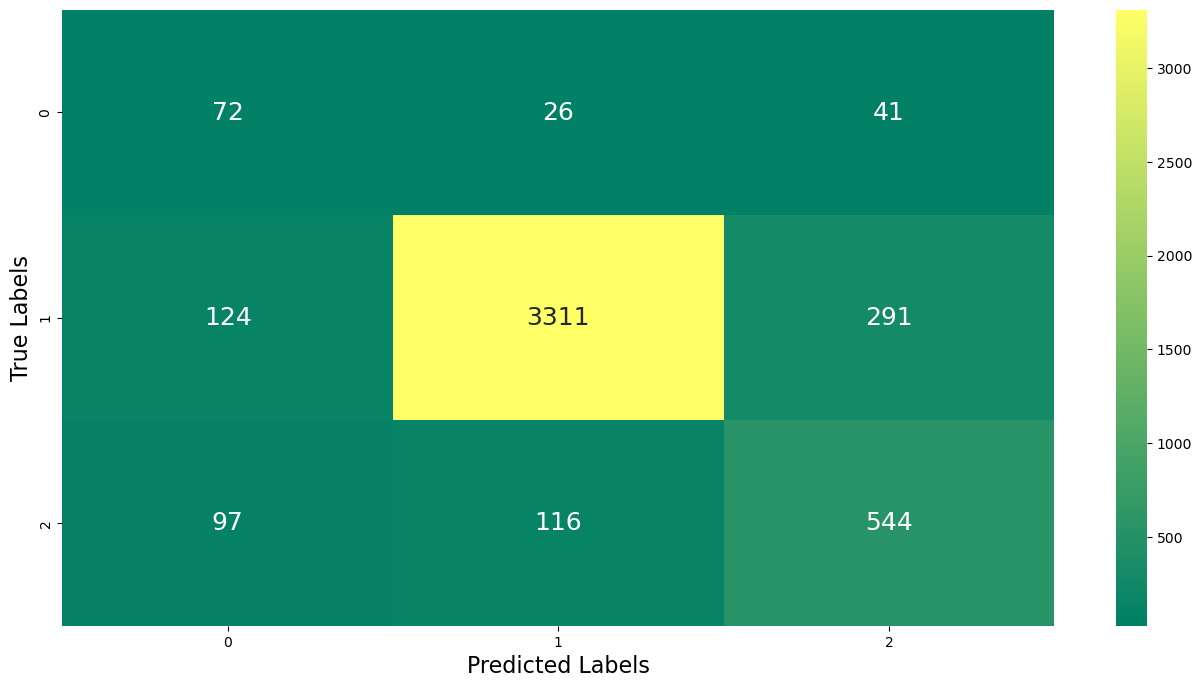

In [69]:
confusion_matrix2(y_test,y_pred_AEcat)

In [70]:
print('AUC:', metric.roc_auc_score_multiclass(y_test, y_pred_AEcat))
print('Accuracy:', metric.accuracy(y_test, y_pred_AEcat))

AUC: {0: 0.7343441329916214, 1: 0.8650691808526954, 2: 0.8163635307206051}
Accuracy: 0.8496321938554738


In [71]:
print('Precision:', metric.macro_precision(y_test, y_pred_AEcat))
print('Recall:',metric.macro_recall(y_test, y_pred_AEcat))
print('F1:', metric.macro_f1(y_test, y_pred_AEcat))

Precision: 0.608538230731889
Recall: 0.7084107556791591
F1: 0.6406676366682946


In [121]:
labels_mice

array([2, 1, 2, ..., 1, 0, 1])

In [119]:
y_onehot = to_categorical(labels_mice, num_classes=3) 

In [120]:
y_onehot

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [122]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = helpers.split_and_scale_data(features, y_onehot)

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import make_classification

In [115]:
# Build the DNN model
model_nn = Sequential()
model_nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(3, activation='softmax'))  # 3 output classes

In [116]:
# Compile the model
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
# Train the model
history = model_nn.fit(X_train_nn, y_train_nn, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)